In [1]:
import feedparser
import pandas as pd
from datetime import datetime
import uuid
import os

# 1. Daten crawlen
feeds = {
    "welt_top": "https://www.welt.de/feeds/topnews.rss",
    "welt_latest": "https://www.welt.de/feeds/latest.rss",
    "welt_politik": "https://www.welt.de/politik/index.rss",
    "welt_wirtschaft": "https://www.welt.de/wirtschaft/index.rss",
    "welt_meinung": "https://www.welt.de/debatte/index.rss",
    "bild": "https://www.bild.de/feed/alles.xml"
}
rows = []

# Schleife zur Datenabfrage
for medium, url in feeds.items():
    feed = feedparser.parse(url)
    for entry in feed.entries:
        row = {
            "id": str(uuid.uuid4()),
            "medium": medium,
            "title": entry.title.strip(),
            "date": entry.get("published", datetime.now().isoformat())
        }
        rows.append(row)

df_new = pd.DataFrame(rows)

## 1.1 Ergebnis anlegen oder erweitern
filename = "data/headlines_dataset.csv"
if os.path.exists(filename):
    df_old = pd.read_csv(filename)
    df_combined = pd.concat([df_old, df_new]).drop_duplicates(subset=["medium", "title"])
else:
    df_combined = df_new

df_combined.to_csv(filename, index=False)
print(f"Aktuell gespeicherte Headlines: {len(df_combined)}")


Aktuell gespeicherte Headlines: 1159


In [3]:
# 1.2 Duplikate, doppelte Leerzeichen und "Horoskop" entfernen
import re

df = pd.read_csv("data/headlines_dataset.csv")

# Titel bereinigen: Leerzeichen vereinheitlichen, trimmen
def clean_title(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df = df[~df['title'].str.contains("horoskop", case=False, na=False)]

df['title_clean'] = df['title'].apply(clean_title)

# Duplikate entfernen
df_deduplicated = df.drop_duplicates(subset=["title_clean"])
# Originaltitel behalten und Spalte entfernen
df_deduplicated = df_deduplicated.drop(columns=["title_clean"])

# Speichern
df_deduplicated.to_csv("data/headlines_dataset_cleaned.csv", index=False)
print(f"Bereinigt gespeichert: {len(df_deduplicated)} eindeutige Titel")


✅ Bereinigt gespeichert: 1002 eindeutige Titel


In [9]:
for title in df_combined["title"].head(5):
    print(title)

70.000 Geschäfte in 10 Jahren – „Die geben einfach auf“
Was deutsche Frauen zum Islam lockt – und welche Rolle Salafisten dabei spielen
Jeder Dritte befürwortet schärfere Bürgergeld-Sanktionen – Mehrheit beklagt Ungerechtigkeit
Julia Simic berichtet über sexuelle Belästigungen als „Teil des Geschäfts“
Iran-Spion ließ sich vor dem US-Kapitol fotografieren


In [120]:
# 2. Manuelles Labeling mit UI
import os
from IPython.display import display
import ipywidgets as widgets

input_file = "data/headlines_dataset_cleaned.csv"
output_file = "data/headlines_labeled.csv"

# Daten laden
df_base = pd.read_csv(input_file)
if os.path.exists(output_file):
    df = pd.read_csv(output_file)
    print("Bestehende Label-Datei geladen.")
else:
    df = df_base.copy()
    df['sentiment'] = None
    df.to_csv(output_file, index=False, encoding="utf-8")
    print("Neue Label-Datei erstellt.")

# Indices ungelabelter Zeilen
df_to_label = df[df['sentiment'].isna()].copy()
indices = df_to_label.index.tolist()
current = {'index': 0}

# Ausgabe-Container
output = widgets.Output()

def save_and_continue(label=None):
    idx = indices[current['index']]
    if label in ["positive", "neutral", "negative"]:
        df.at[idx, 'sentiment'] = label
        df.to_csv(output_file, index=False, encoding="utf-8")
        print(f"Gespeichert: {label}")
    current['index'] += 1
    show_next()

def show_next():
    output.clear_output()
    with output:
        if current['index'] >= len(indices):
            print(f"Alle Headlines wurden gelabelt!\n Gespeichert als: {output_file}")
            return

        idx = indices[current['index']]
        row = df.loc[idx]

        print(f"\nNoch zu labeln: {len(indices) - current['index']} von {len(indices)}")
        print(f"Titel : {row['title']}")
        print(f"Medium: {row['medium']}")
        print(f"Datum : {row['date']}")

        # Buttons mit Farbe definieren
        positive_btn = widgets.Button(description="+ Positiv", style={'button_color': 'lightgreen'})
        neutral_btn  = widgets.Button(description="# Neutral", style={'button_color': 'lightgray'})
        negative_btn = widgets.Button(description="- Negativ", style={'button_color': 'lightcoral'})
        skip_btn     = widgets.Button(description="Skip", style={'button_color': 'lightyellow'})
        quit_btn     = widgets.Button(description="Beenden", style={'button_color': 'lightblue'})

        # Button-Leiste erstellen
        buttons = widgets.HBox([
        positive_btn, neutral_btn, negative_btn, skip_btn, quit_btn
        ])

        def on_click(btn):
            label_map = {
                "+ Positiv": "positive",
                "# Neutral": "neutral",
                "- Negativ": "negative",
                "Skip": None,
                "Beenden": "quit"
            }
            label = label_map[btn.description]
            if label == "quit":
                output.clear_output()
                print("Beendet.")
            else:
                save_and_continue(label)

        for b in buttons.children:
            b.on_click(on_click)

        display(buttons)

# Startanzeige
show_next()
display(output)


Bestehende Label-Datei geladen.


Output()

In [4]:
## 2.1 Finale Labeling Ergebnisse
print(df["sentiment"].value_counts())
# Fehlende (NaN) Einträge zählen
print("NaN-Werte:", df["sentiment"].isna().sum())

sentiment
neutral     371
negative    353
positive    276
Name: count, dtype: int64
NaN-Werte: 0


In [1]:
# 3. Daten splitten

import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/headlines_labeled.csv")
df = df.dropna(subset=["sentiment"])

# 1.Split: 80 % Training, 20 % Rest
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["sentiment"],
    random_state=42
)

# 2. Split: Rest → 10 % Val, 10 % Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["sentiment"],
    random_state=42
)

# Kontrolle
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")
print("\nVerteilung im Training:")
print(train_df["sentiment"].value_counts(normalize=True))


Train: 800
Validation: 100
Test: 100

Verteilung im Training:
sentiment
neutral     0.37125
negative    0.35250
positive    0.27625
Name: proportion, dtype: float64


In [82]:
## 3.1 Label encoding
from sklearn.preprocessing import LabelEncoder

# Labels in Zahlen umwandeln
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["sentiment"])
val_df["label"] = label_encoder.transform(val_df["sentiment"])
test_df["label"] = label_encoder.transform(test_df["sentiment"])

# Klassenreihenfolge merken
label_names = label_encoder.classes_.tolist()
print("Labels:", label_names)

# Speichere Label-Klassen in Datei (für späteres Nachladen)
with open("data/label_classes.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(label_names))


Labels: ['negative', 'neutral', 'positive']


In [3]:
# 4. Dataset vorbereiten und Tokenizen
from datasets import Dataset
from transformers import AutoTokenizer

# Tokenizer laden
tokenizer = AutoTokenizer.from_pretrained("deepset/gbert-base")

# Nur Titel & Label nehmen
train_ds = Dataset.from_pandas(train_df[["title", "label"]])
val_ds = Dataset.from_pandas(val_df[["title", "label"]])
test_ds = Dataset.from_pandas(test_df[["title", "label"]])

# Tokenisierungsfunktion
def tokenize(example):
    return tokenizer(example["title"], padding="max_length", truncation=True, max_length=64)

# Tokenisierung
train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [4]:
## 4.1 Modell definieren
from transformers import AutoModelForSequenceClassification

# Anzahl deiner Klassen
num_labels = len(label_names)  # z. B. 3 (positive, neutral, negative)

# Modell laden
model = AutoModelForSequenceClassification.from_pretrained(
    "deepset/gbert-base",
    num_labels=num_labels
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# 5. Training vorbereiten
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate
import torch
import random
import numpy as np

# Reproduzierbarkeit sicherstellen
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

# Metrik berechnen
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

# Trainingsparameter
training_args = TrainingArguments(
    output_dir="./results_v3_earlystop",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=7e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10, 
    weight_decay=0.05,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    logging_dir="./logs_v3_earlystop",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    seed=42
)
callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]

# Huggingface Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\viet\AppData\Local\Temp\ipykernel_5924\828392823.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
## 5.1 Training
trainer.train()


C:\Users\viet\Desktop\Projekt\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.321500,0.881545,0.650000,0.654659
2,0.279800,0.950294,0.650000,0.654762
3,0.227100,1.022181,0.670000,0.674903
4,0.158000,1.164481,0.620000,0.607567
5,0.124500,1.246113,0.610000,0.611512
6,0.096200,1.334940,0.610000,0.612698
7,0.064400,1.375325,0.610000,0.610022
8,0.049400,1.428655,0.620000,0.623306
9,0.046600,1.432307,0.620000,0.622587
10,0.053800,1.432907,0.620000,0.622587


C:\Users\viet\Desktop\Projekt\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\viet\Desktop\Projekt\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\viet\Desktop\Projekt\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\viet\Desktop\Projekt\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\viet\Desktop\Projekt\.venv\Lib\site-packages\to

TrainOutput(global_step=500, training_loss=0.14212095260620117, metrics={'train_runtime': 1272.1194, 'train_samples_per_second': 6.289, 'train_steps_per_second': 0.393, 'total_flos': 263113417728000.0, 'train_loss': 0.14212095260620117, 'epoch': 10.0})

In [116]:
# Training test
text = "Mann tötet 200 Menschen"

inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)
predicted_class_id = outputs.logits.argmax(dim=-1).item()

# Ursprüngliches Label zurückübersetzen:
label_encoder.inverse_transform([predicted_class_id])[0]


'neutral'

In [11]:
## 5.2 Trainiertes Modell speichern
trainer.save_model("./saved_best_model")
tokenizer.save_pretrained("./saved_best_model")

In [15]:
# 6. Evaluation
test_results = trainer.evaluate(eval_dataset=test_ds)
print(test_results)


C:\Users\viet\Desktop\Projekt\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.9708534479141235, 'eval_accuracy': 0.7, 'eval_f1': 0.7023474564087818, 'eval_runtime': 4.0967, 'eval_samples_per_second': 24.41, 'eval_steps_per_second': 0.976, 'epoch': 10.0}


In [70]:
# Vorhersage auf Testset
predictions = trainer.predict(test_ds)
pred_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids


C:\Users\viet\Desktop\Projekt\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Klassifikationsbericht:
              precision    recall  f1-score   support

    negative       0.73      0.75      0.74        36
     neutral       0.66      0.57      0.61        37
    positive       0.71      0.81      0.76        27

    accuracy                           0.70       100
   macro avg       0.70      0.71      0.70       100
weighted avg       0.70      0.70      0.70       100

Balanced Accuracy: 0.711


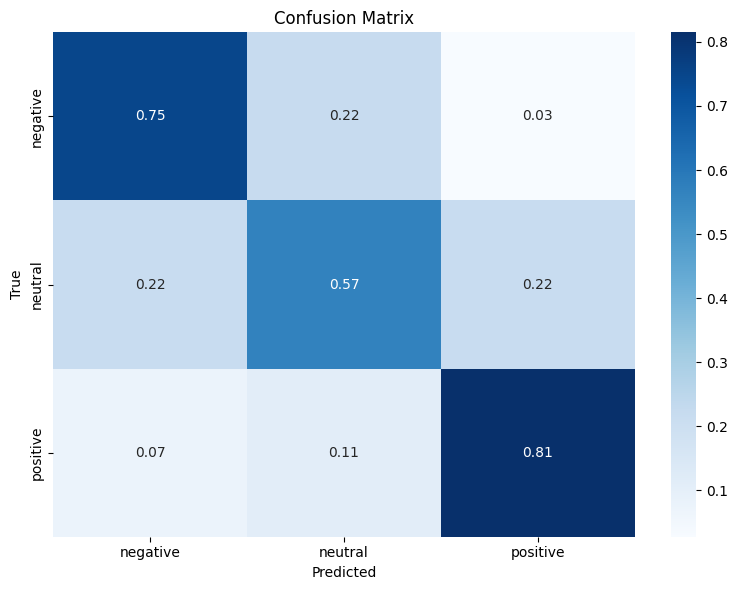

In [121]:
## 6.1 Visualisierung der Testset

from sklearn.metrics import classification_report, confusion_matrix,balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Bericht
print("Klassifikationsbericht:")
print(classification_report(true_labels, pred_labels, target_names=label_names))

balanced_acc = balanced_accuracy_score(true_labels, pred_labels)
print(f"Balanced Accuracy: {balanced_acc:.3f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels, normalize='true')

# Visualisierung
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(cm, index=label_names, columns=label_names), annot=True, cmap="Blues", fmt=".2f")
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


In [21]:
## 6.2 Finales Modell speichern
model.save_pretrained("final_model")
tokenizer.save_pretrained("final_model")

('final_model\\tokenizer_config.json',
 'final_model\\special_tokens_map.json',
 'final_model\\vocab.txt',
 'final_model\\added_tokens.json',
 'final_model\\tokenizer.json')

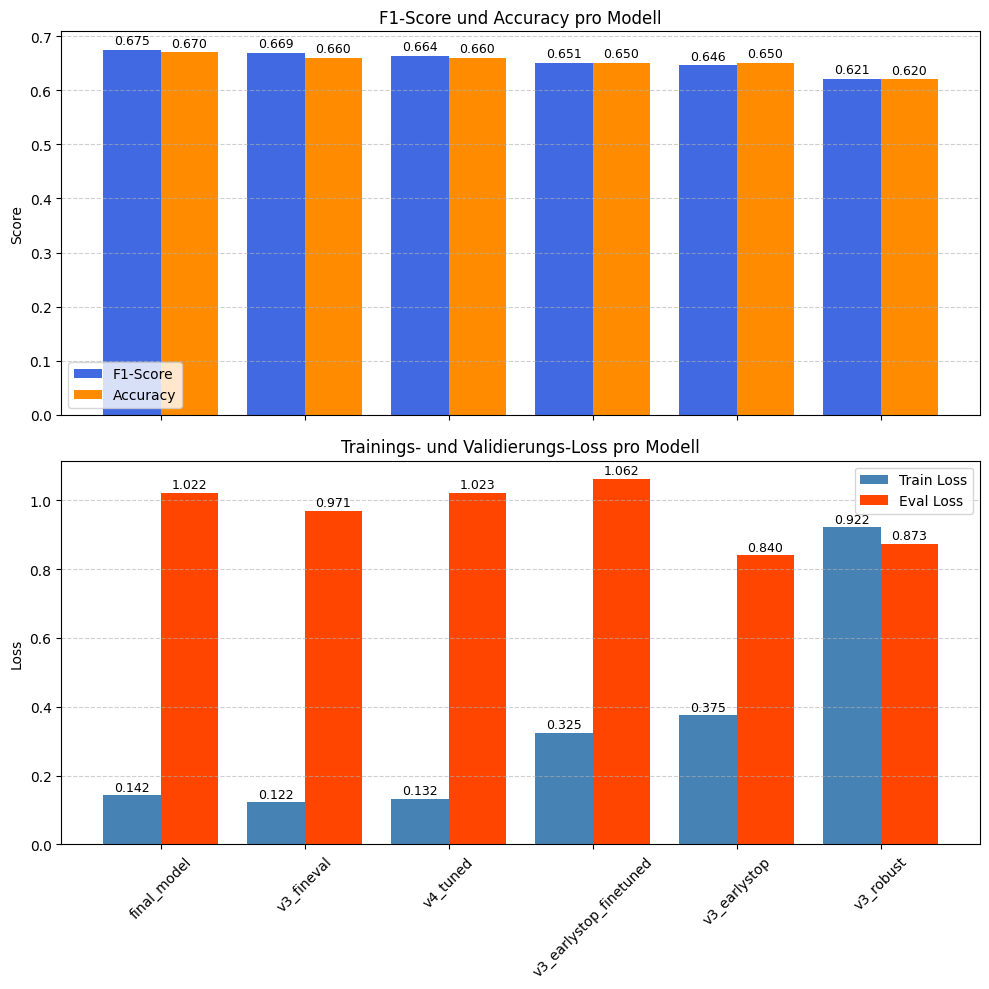

In [112]:
## 6.3 Vergleich mit anderen Modellen
import pandas as pd
import matplotlib.pyplot as plt

# Daten laden und vereinheitlichen
df_exp = pd.read_csv("experiments/model_results.csv")
df_final = pd.read_csv("final_model/final_model_result.csv")

df = pd.concat([df_exp, df_final], ignore_index=True)
df.columns = ['model_name', 'train_loss', 'eval_loss', 'accuracy', 'f1_score']
df = df.sort_values(by="f1_score", ascending=False)

# Plot erstellen
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# Farben
f1_color = "royalblue"
acc_color = "darkorange"
train_color = "steelblue"
eval_color = "orangered"

# Plot: F1 und Accuracy
bar_width = 0.4
x = range(len(df))

axes[0].bar(x, df["f1_score"], width=bar_width, label="F1-Score", color=f1_color)
axes[0].bar([i + bar_width for i in x], df["accuracy"], width=bar_width, label="Accuracy", color=acc_color)

axes[0].set_ylabel("Score")
axes[0].set_title("F1-Score und Accuracy pro Modell")
axes[0].set_xticks([i + bar_width / 2 for i in x])
axes[0].set_xticklabels(df["model_name"], rotation=45)
axes[0].legend()
axes[0].grid(axis="y", linestyle="--", alpha=0.6)
# Werte oberhalb der F1-Balken einzeichnen (senkrecht)
for i, v in enumerate(df["f1_score"]):
    axes[0].text(i, v + 0.005, f"{v:.3f}", ha='center', va='bottom', fontsize=9, color="black")
for i, v in enumerate(df["accuracy"]):
    axes[0].text(i + bar_width, v + 0.005, f"{v:.3f}", ha='center', va='bottom', fontsize=9, color="black")

# Plot: Train vs Eval Loss
axes[1].bar(x, df["train_loss"], width=bar_width, label="Train Loss", color=train_color)
axes[1].bar([i + bar_width for i in x], df["eval_loss"], width=bar_width, label="Eval Loss", color=eval_color)

axes[1].set_ylabel("Loss")
axes[1].set_title("Trainings- und Validierungs-Loss pro Modell")
axes[1].set_xticks([i + bar_width / 2 for i in x])
axes[1].set_xticklabels(df["model_name"], rotation=45)
axes[1].legend()
axes[1].grid(axis="y", linestyle="--", alpha=0.6)
for i, v in enumerate(df["train_loss"]):
    axes[1].text(i, v + 0.005, f"{v:.3f}", ha='center', va='bottom', fontsize=9, color="black")
for i, v in enumerate(df["eval_loss"]):
    axes[1].text(i + bar_width, v + 0.005, f"{v:.3f}", ha='center', va='bottom', fontsize=9, color="black")

plt.tight_layout()
plt.show()


In [84]:
# 7. Post-Processing: Nachgestellte Reglen
import pandas as pd
import json
from tqdm import tqdm
import spacy
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch


model = AutoModelForSequenceClassification.from_pretrained("final_model")
model.eval()
tokenizer = AutoTokenizer.from_pretrained("final_model")
with open("data/label_classes.txt", "r", encoding="utf-8") as f:
    label_names = [line.strip() for line in f]

# Sicherstellen, dass spaCy geladen ist
nlp = spacy.load("de_core_news_sm")

# Inhaltsebene berechnen
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    outputs = model(**inputs)
    pred = outputs.logits.argmax(dim=1).item()
    return label_names[pred]

# Wahrscheinlichkeit berechnen
def predict_sentiment_probs(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1).detach().numpy()[0]
    return {label: round(float(p), 3) for label, p in zip(label_names, probs)}

# Negative Schlüsselwörter laden
with open("data/negative_keywords_news.json", "r", encoding="utf-8") as f:
        negative_keywords = set(json.load(f))
    
# Regel-Funktion mit spaCy
def predict_with_rules(text):
    model_prediction = predict_sentiment(text)
    doc = nlp(text.lower())
    
    found_negatives = [token.text for token in doc if token.lemma_ in negative_keywords]

    if model_prediction == "neutral" and found_negatives:
        return {
            "final_label": "negative",
            "modell_label": model_prediction,
            "regel_override": True,
            "wahrscheinlichkeiten": predict_sentiment_probs(text),
            "begruendung": f"Folgende Wörter deuten auf Negativstimmung: {', '.join(found_negatives)}",
            "text": text
        }

    return {
        "final_label": model_prediction,
        "modell_label": model_prediction,
        "regel_override": False,
        "wahrscheinlichkeiten": predict_sentiment_probs(text),
        "begruendung": "Keine kritischen Schlüsselwörter erkannt.",
        "text": text
    }

In [119]:
# Beispielausgabe
example = "Mann verliert sein Bein"
result = predict_with_rules(example)

print("Titel:", result["text"])
print("Sprachebene:", result["modell_label"])
print("Inhaltsebene:", result["final_label"])
print("Modell-Wahrscheinlichkeiten:", result["wahrscheinlichkeiten"])
print("Regel angewendet:", result["regel_override"])
print("Begründung:", result["begruendung"])

Titel: Mann verliert sein Bein
Sprachebene: neutral
Inhaltsebene: neutral
Modell-Wahrscheinlichkeiten: {'negative': 0.241, 'neutral': 0.749, 'positive': 0.01}
Regel angewendet: False
Begründung: Keine kritischen Schlüsselwörter erkannt.


In [81]:
# 8. Mini-WebApp mit Gradio
import gradio as gr

def hybrid_sentiment(text):
    if not text.strip():
        return (
            "Kein Text eingegeben.",
            "-", "-", "-", "-"
        )
    result = predict_with_rules(text)
    return (
        result["final_label"],
        result["modell_label"],
        str(result["regel_override"]),
        result["begruendung"],
        str(result["wahrscheinlichkeiten"])
    )

demo = gr.Interface(
    fn=hybrid_sentiment,
    inputs=gr.Textbox(label="Nachrichtentitel", placeholder="z. B. 'Mann tötet Frau in Berlin'"),
    outputs=[
        gr.Textbox(label="Sprachebene (Modell-Vorhersage)"),
        gr.Textbox(label="Inhaltsebene (Regelbasiert)"),
        gr.Textbox(label="Regel angewendet"),
        gr.Textbox(label="Begründung"),
        gr.Textbox(label="Modell-Wahrscheinlichkeiten")
    ],
    title="Stimmungsanalyse deutscher Nachrichtentitel",
    description="Dieses Tool kombiniert ein maschinell gelerntes Modell mit regelbasierten Filtern zur Analyse der Stimmung in Nachrichtentiteln."
).launch()

* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.
